# Chapter 10 - The Jackknife and the Bootstrap
Implementing (and exploring) concepts from Computer Age Statistical Inference. Email me on sid \dot ravi1 \at gmail.com if you find any mistakes.
This was written for learning purposes so apologies for the crappy varnames and inefficient code.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm_notebook as tqdm

In [3]:
sns.set_palette("Set1")

## Section 10.1

In [4]:
data = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/kidney.txt", sep=" ")

In [5]:
x = data.age.values
y = data.tot.values

In [6]:
from functools import partial
lowess_part = partial(lowess, it=5, frac=1/3, return_sorted=False)

In [10]:
def get_jackknife(estimator_func, x, y):
    
    n_xs = len(x)
    mask = np.ones(n_xs, dtype=bool)
    x_unique = pd.unique(x)
    n_unique = len(x_unique)
    
    jackknife = np.full((n_xs, n_unique), np.nan)
    
    for i in range(n_xs):
        mask_i = mask.copy()
        mask_i[i] = False
        
        xi = x[mask_i]
        yi = y[mask_i]
        
        args = np.argwhere(np.isin(x_unique, pd.unique(xi))).squeeze()
        
        yhat_i = estimator_func(yi, xi)
        jackknife[i, args] = pd.unique(yhat_i)
    
    return jackknife

In [14]:
def get_bootstrap(estimator_func, x, y):

    x_unique = pd.unique(x)
    yhat_unique = pd.unique(y)

    # bootstrap
    n_boots = len(data)
    n_points = len(data)
    n_unique = len(x_unique)

    bootstrap_ys = np.full((n_boots, n_unique), np.nan)

    for i in range(n_boots):

        mask = np.sort(np.random.randint(0, n_points, size=n_points))

        x_jk = x[mask]
        y_jk = y[mask]

        args = np.argwhere(np.isin(x_unique, pd.unique(x_jk))).squeeze()

        yhat_jk = estimator_func(y_jk, x_jk)

        bootstrap_ys[i, args] = pd.unique(yhat_jk)
    
    return bootstrap_ys

In [15]:
get_jackknife(lowess_part, x, y)

array([[        nan,  1.83142465,  1.57507957, ..., -3.49997658,
        -3.66417965, -4.16114041],
       [ 1.58326826,  1.43653946,  1.26903047, ..., -3.49978476,
        -3.66344327, -4.15893215],
       [ 2.92714387,  2.47484366,  2.04402941, ..., -3.4998356 ,
        -3.6634944 , -4.15898263],
       ...,
       [ 2.24379219,  1.94976069,  1.65622005, ...,         nan,
        -3.33083482, -3.73516524],
       [ 2.2532117 ,  1.95588254,  1.65933777, ..., -3.82064507,
                nan, -4.62743906],
       [ 2.24379218,  1.94976068,  1.65622005, ..., -3.26116522,
        -3.39565958,         nan]])

### Figure 10.1

In [16]:
bootstrap_ys = get_bootstrap(lowess_part, x, y)
theta_i = get_jackknife(lowess_part, x, y)
n_points, n_unique = theta_i.shape

bootstrapped_se = np.nanstd(bootstrap_ys, axis = 0)

theta_dot = np.nansum(theta_i, axis=0) / n_points
jack_se = (np.nansum((theta_i - theta_dot)**2, axis=0) * ((n_points - 1)/n_points))**(1/2)

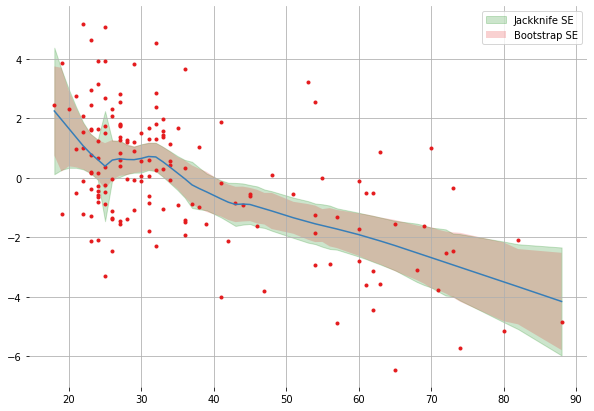

In [27]:
# plot
plt.subplots(figsize=(10,7))
yhat = lowess(y, x, it=5, frac=1/3, return_sorted=False)
plt.plot(x, y, ".")
plt.plot(x, yhat, "-", )

x_unique = pd.unique(x)
yhat_unique = pd.unique(yhat)
plt.grid()
sns.despine(left=True, bottom=True)
plt.fill_between(x_unique, yhat_unique - 2*jack_se, yhat_unique + 2*jack_se, 
                 color = 'green', alpha=0.2, label='Jackknife SE')
plt.fill_between(x_unique, yhat_unique - 2*bootstrapped_se, yhat_unique + 2*bootstrapped_se, alpha=0.2, label='Bootstrap SE')
plt.legend()
plt.savefig("../../../../sidravi1.github.io/assets/20200123_lowess.png")

## Section 10.2

In [28]:
from scipy.linalg import eig

In [29]:
data = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/student_score.txt", sep= " ")

In [30]:
def eigenratio(df):
    corr_mat = df.corr()
    eig_vals, _ = eig(corr_mat)
    return np.max(eig_vals)/np.sum(eig_vals)

In [31]:
corr_mat = data.corr()
with pd.opcorr_mat.

,mech,vecs,alg,analy,stat
mech,1.000000,0.497807,0.756036,0.653476,0.535774
vecs,0.497807,1.000000,0.592262,0.507135,0.378604
alg,0.756036,0.592262,1.000000,0.762755,0.669825
analy,0.653476,0.507135,0.762755,1.000000,0.737671
stat,0.535774,0.378604,0.669825,0.737671,1.000000


In [41]:
pd.set_option('precision', 2)
corr_mat

,mech,vecs,alg,analy,stat
mech,1.00,0.50,0.76,0.65,0.54
vecs,0.50,1.00,0.59,0.51,0.38
alg,0.76,0.59,1.00,0.76,0.67
analy,0.65,0.51,0.76,1.00,0.74
stat,0.54,0.38,0.67,0.74,1.00


In [42]:
def get_bootstrap(estimator_func, data, n_reps):

    # bootstrap
    theta_hats = np.full(n_reps, np.nan)

    for i in range(n_reps):

        df = data.sample(frac=1.0, replace=True)
        theta_hats[i] = estimator_func(df)

    return theta_hats

In [43]:
def get_jacknife(estimator_func, data):

    # jackknife
    n_recs = len(data)
    theta_hats = np.full(n_recs, np.nan)
    
    for i in range(n_recs):

        df = data.drop(i)
        theta_hats[i] = estimator_func(df)

    return theta_hats

In [44]:
theta_hats = get_bootstrap(eigenratio, data, 2000)

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  if __name__ == '__main__':


In [45]:
theta_hats_jk = get_jacknife(eigenratio, data)

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  # Remove the CWD from sys.path while we load stuff.


### Figure 10.2

In [52]:
se_bootstrap = np.std(theta_hats, ddof=1)

theta_dot = theta_hats_jk.mean()
n = len(data)
se_jack = (((n - 1) / n) * np.sum((theta_hats_jk - theta_dot)**2))**(1/2)

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


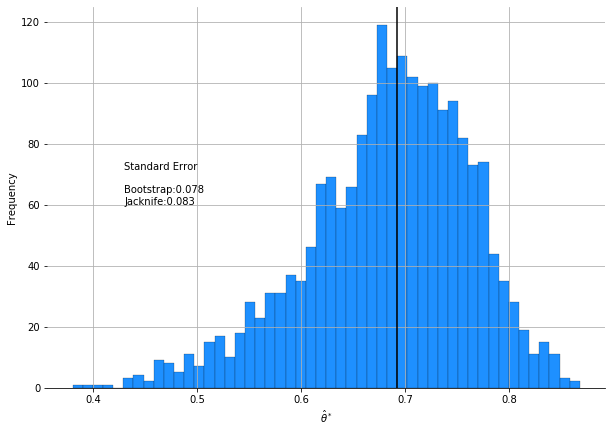

In [58]:
plt.subplots(figsize=(10,7))
plt.hist(theta_hats, bins=50, lw=0.2, edgecolor='k', color='dodgerblue');
plt.axvline(eigenratio(data), color='k')
plt.xlabel(r"$\hat{\theta}^*}$")
plt.ylabel("Frequency")
plt.annotate("Standard Error\n\nBootstrap:{:0.3f}\nJacknife:{:0.3f}".format(se_bootstrap, se_jack), xy=(0.43, 60))
plt.grid()
sns.despine(left=True)

plt.savefig("../../../../sidravi1.github.io/assets/20200123_eigratio.png")

## Section 10.3

### Multisample Bootstrap

In [292]:
data = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv")

In [316]:
ALL = data.filter(like='ALL')
AML = data.filter(like='AML')

In [318]:
mediff = AML.loc[135].median() - ALL.loc[135].median()
mediff

0.23509301599999988

In [338]:
B = 500
boots_mediff = []

for i in range(500):
    ALL_sample = ALL.loc[135].sample(frac=1, replace=True)
    AML_sample = AML.loc[135].sample(frac=1, replace=True)
    
    boots_mediff.append(AML_sample.median() - ALL_sample.median())
    

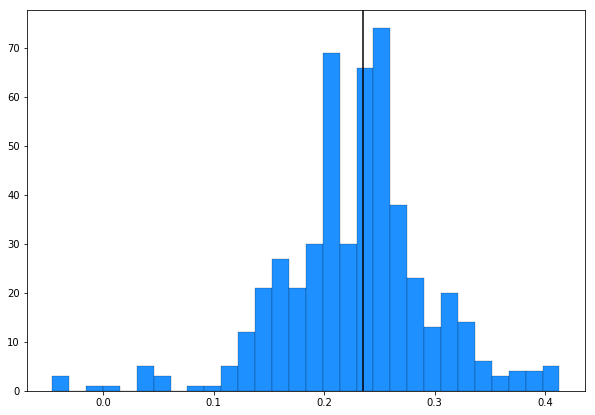

In [339]:
plt.subplots(figsize=(10,7))
plt.hist(boots_mediff, bins=30, lw=0.2, edgecolor='k', color='dodgerblue')
plt.axvline(mediff, color='k');

# Section 10.4

## The Parametric Bootstrap

In [62]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Poisson
from scipy.stats import poisson

In [63]:
data = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/gfr.txt", header=None, names=['vals'])

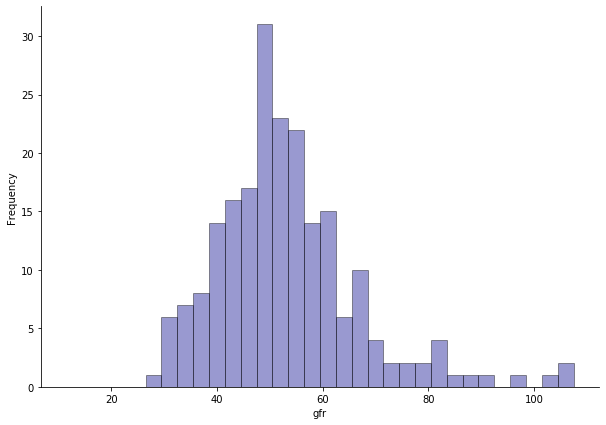

In [160]:
plt.subplots(figsize=(10,7))

edges = np.arange(13, 110, 3)
xs = (edges[1:] + edges[:-1])/2

df = pd.DataFrame({'xs':xs, 'intercept':np.ones_like(xs)})
counts, bins, patches = plt.hist(data.vals, bins=edges, color='darkblue', alpha=0.4, 
                                 align='left', ec = 'k')
df['y'] = counts
plt.xlabel("gfr")
plt.ylabel("Frequency")
sns.despine()

Not quite the same plot as the book but close enough. Discrepancy seems to be due to edge values.

In [163]:
deg_freedom = 7

for d in range(2, deg_freedom+1):
    df["xs"+str(d)] = xs**d


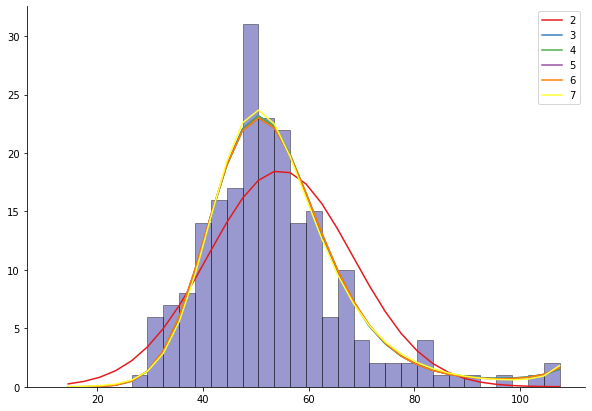

In [116]:
endog = df.y.values

exog_cols = ['xs', 'intercept']
models = []
lnk = sm.families.links
plt.subplots(figsize=(10,7))
plt.hist(data.vals, bins=edges,  align='left', alpha=0.4, 
         color='darkblue', ec = 'k')
all_fitted_vals = {}
for d in range(2, deg_freedom + 1):
    exog_cols.append('xs'+str(d))
    model = sm.GLM(endog=df.y.values, exog=df[exog_cols].values, family=sm.families.Poisson()).fit()
    plt.plot(xs, model.fittedvalues, label=d)
    
    # Generate samples from fitted model
    samples = np.random.poisson(model.fittedvalues, size=(200, len(df)))
    
    # For each sample, find mu
    fitted_vals = []
    
    for sample in samples:
        sample_model = sm.GLM(endog=sample, exog=df[exog_cols].values, family=sm.families.Poisson()).fit()
        fitted_vals.append(sample_model.fittedvalues)
        
    # Take the std of mu
    all_fitted_vals[d] = np.array(fitted_vals).std(axis=0, ddof=1)

sns.despine()
plt.legend()
plt.savefig("../../../../sidravi1.github.io/assets/20200123_gfrdata.png")

In [122]:
boot_sd_df = pd.DataFrame(all_fitted_vals, index=xs)
boot_sd_df.head()

,2,3,4,5,6,7
14.5,0.11,2.60e-03,0.02,0.03,0.03,0.13
17.5,0.18,1.01e-02,0.03,0.04,0.03,0.14
20.5,0.27,3.30e-02,0.07,0.07,0.06,0.19
23.5,0.38,9.13e-02,0.14,0.15,0.14,0.27
26.5,0.51,2.12e-01,0.27,0.30,0.31,0.42


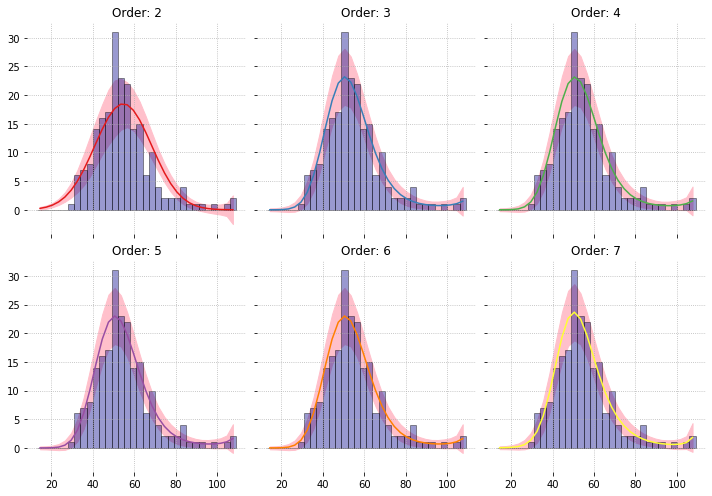

In [181]:
f, axes = plt.subplots(2, 3, figsize=(10,7), sharex=True, sharey=True)
exog_cols = ['xs', 'intercept']
for ax, d in zip(axes.ravel(), range(2, deg_freedom + 1)):
    ax.hist(data.vals, bins=edges,  align='mid', alpha=0.4, 
         color='darkblue', ec = 'k')
    color = sns.color_palette('Set1')[d - 2]
    exog_cols.append('xs'+str(d))
    model = sm.GLM(endog=df.y.values, exog=df[exog_cols].values, family=sm.families.Poisson()).fit()
    ax.plot(xs, model.fittedvalues, color=color)
    ax.fill_between(xs, model.fittedvalues - 1.96*boot_sd_df.loc[:, 7].values,
                    model.fittedvalues + 1.96*boot_sd_df.loc[:, 7].values, 
                    color = 'pink')
    ax.set_title("Order: " + str(d))
    ax.grid(ls=":")
    sns.despine(left=True, bottom = True)
plt.tight_layout()
plt.savefig("../../../../sidravi1.github.io/assets/20200123_gfr_se.png")

The 7th order is not that much better in our case. I suspect this is due to binning difference we observed earlier.

### Non-parametrics bootstrap estimate

In [168]:
nonparam_samples = np.random.choice(data.vals, size=(200, len(data.vals)))

In [169]:
bin_counts = []
for sample in nonparam_samples:
    hist, _ = np.histogram(sample, bins = edges)
    bin_counts.append(hist)

In [170]:
boot_sd_df['np'] = np.array(bin_counts).std(axis=0)

In [93]:
boot_sd_df.loc[np.arange(20.5, 93, 9),:]

,2,3,4,5,6,7,np
20.5,0.26,0.03,0.07,0.06,0.05,0.14,0.00
29.5,0.62,0.43,0.51,0.51,0.59,0.52,1.08
38.5,0.98,1.31,1.32,1.40,1.76,1.62,2.81
47.5,1.30,2.14,2.10,2.22,2.46,2.35,4.03
56.5,1.48,1.85,1.93,2.07,1.89,2.08,4.10
65.5,1.26,1.13,1.16,1.30,1.39,1.48,2.58
74.5,0.92,0.61,0.62,0.73,0.79,0.80,1.40
83.5,0.48,0.30,0.39,0.41,0.43,0.53,2.03
92.5,0.16,0.19,0.27,0.33,0.30,0.34,1.01


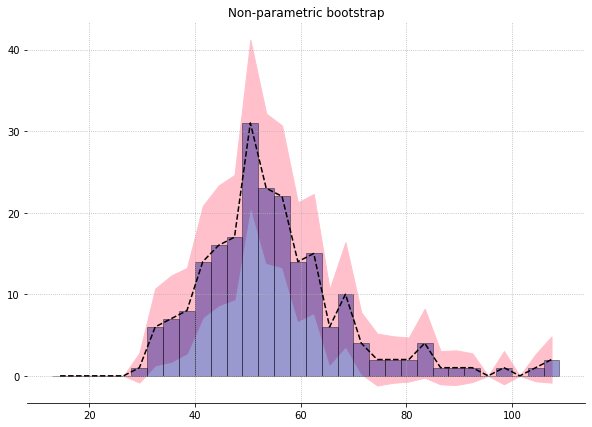

In [184]:
f, axes = plt.subplots(figsize=(10,7))
plt.hist(data.vals, bins=edges,  align='mid', alpha=0.4, 
     color='darkblue', ec = 'k')
color = 'red'
exog_cols.append('xs'+str(d))
plt.plot(xs, df.y, "--k", label='non-param')
plt.fill_between(xs, df.y - 1.96*boot_sd_df.loc[:, 'np'].values,
                df.y + 1.96*boot_sd_df.loc[:, 'np'].values, 
                color = 'pink')
plt.title("Non-parametric bootstrap")
plt.grid(ls=":")
sns.despine(left=True)
plt.savefig("../../../../sidravi1.github.io/assets/20200123_gfr_se_np.png")

## Eigenvalues example: student score data

- Fit a 5 dimensional bivariate normal. 
- Generate samples from the bivariate normal
- Calculate eigenratio on each of these samples
- Calculate std err
- Plot

In [330]:
data = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/student_score.txt", sep= " ")

In [331]:
def eigenratio2(arr):
    corr_mat = np.corrcoef(arr, rowvar=False)
    eig_vals, _ = eig(corr_mat)
    return np.max(eig_vals)/np.sum(eig_vals)

In [332]:
mean = data.mean().values
covar = np.cov(data, rowvar=False)

In [333]:
samples = np.random.multivariate_normal(mean, covar, size=(2000, len(data)))

In [334]:
eigr_ls = []
for sample in samples:
    eigr_ls.append(eigenratio2(sample))

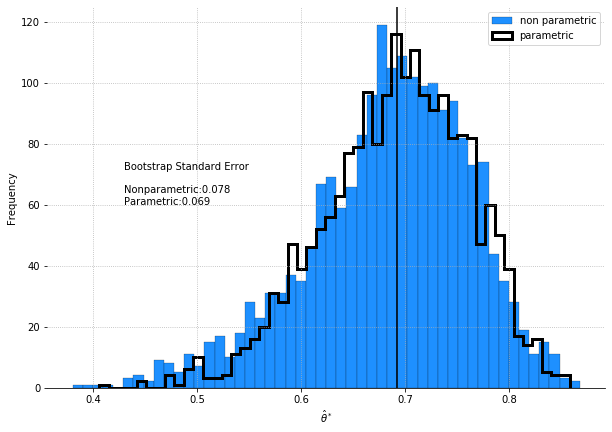

In [335]:
plt.subplots(figsize=(10,7))
plt.hist(theta_hats, bins=50, lw=0.2, edgecolor='k', color='dodgerblue', label='non parametric');
plt.hist(eigr_ls, histtype='step', color='k', lw=3, bins=50, label = 'parametric');
plt.axvline(eigenratio(data), color='k')
plt.xlabel(r"$\hat{\theta}^*}$")
plt.ylabel("Frequency")
plt.annotate("Bootstrap Standard Error\n\nNonparametric:{:0.3f}\nParametric:{:0.3f}".format(se_bootstrap, np.std(eigr_ls)), xy=(0.43, 60))
plt.grid(ls=":")
plt.legend()
sns.despine(left=True)
plt.savefig("../../../../sidravi1.github.io/assets/20200123_eigenratio_para.png")

# Section 10.5

In [197]:
data = pd.read_csv("https://web.stanford.edu/~hastie/CASI_files/DATA/leukemia_big.csv")

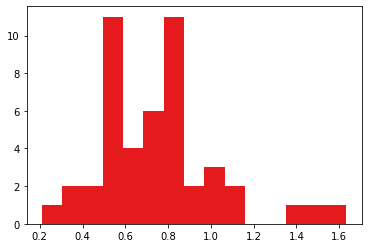

In [198]:
data_all = data.filter(like='ALL').loc[135].sort_values()
plt.hist(data_all, bins=15);

In [314]:
if_all = data_all - data_all.mean()

In [353]:
def get_IF(data_sr, alpha):
    low_α = np.percentile(data_sr, alpha*100, 
                                  interpolation = 'lower')
    high_α = np.percentile(data_sr, (1-alpha)*100, 
                                  interpolation = 'higher')   
    mask_low = (data_sr < low_α) 
    mask_high = (data_sr > high_α)

    vals = data_sr.copy()
    vals[mask_low] = low_α
    vals[mask_high] = high_α
    
    return (vals - vals.mean()) / (1 - 2*alpha)

def get_trimmed(data_sr, alpha):
    low_α = np.percentile(data_sr, alpha*100, 
                                  interpolation = 'higher')
    high_α = np.percentile(data_sr, (1-alpha)*100, 
                                  interpolation = 'lower')  
    
    mask02_low = (data_sr < low_α) 
    mask02_high = (data_sr > high_α)
    
    return data_sr[~(mask02_low | mask02_high)]

## Figure 10.7

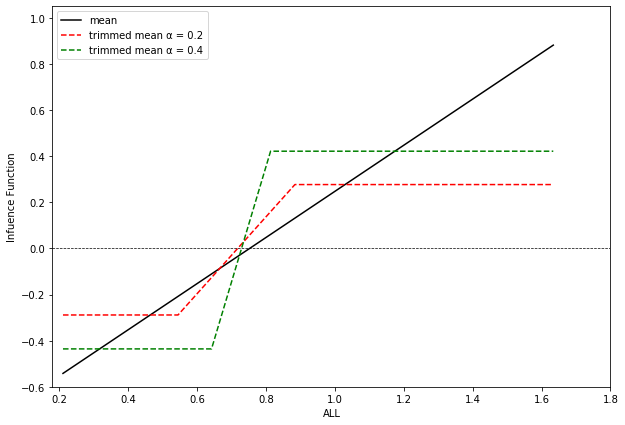

In [348]:
plt.figure(figsize =(10,7))
plt.plot(data_all, if_all, "-k", label="mean")
get_IF(data_all, 0.2)
plt.plot(data_all, get_IF(data_all, 0.2) , "--r", label='trimmed mean α = 0.2')
data, get_IF(data_all, 0.4)
plt.plot(data_all, get_IF(data_all, 0.4) , "--g", label='trimmed mean α = 0.4')
plt.axhline(0.0, ls="--", color='k', lw=0.7)
plt.xlabel("ALL")
plt.ylabel("Infuence Function")
plt.xlim(0.18, 1.8)
plt.ylim(-0.6, 1.05)
plt.legend();

## Table 10.3

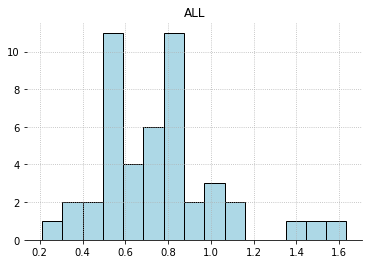

In [336]:
plt.hist(data_all, bins=15, ec = 'k', color='lightblue')
plt.grid(ls = ":")
sns.despine(left = True)
plt.title("ALL")

plt.savefig("../../../../sidravi1.github.io/assets/20200123_all_hist.png")

In [354]:
mean_tr = []
mean_if = []
res = []
for α in [0, 0.1, 0.2, 0.3, 0.4, 0.5]:
    mean_tr = []
    mean_if = []
    for i in range(1000):
        sample= np.random.choice(data_all, size=len(data_all))
        trimmed_sample = get_trimmed(sample, α)
        mean_tr.append(trimmed_sample.mean())
        N = len(trimmed_sample)
        mean_if.append(get_IF(sample, α).std()/np.sqrt(len(data_all)))
    res.append({"Trim":α, 
                "Trimmed Mean": np.mean(mean_tr), 
                "Bootstrap sd":np.std(mean_tr), 
                "IFse":np.mean(mean_if)})

/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/sidravi/anaconda3/envs/experiments/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


In [355]:
get_trimmed(sample, 0.5)

array([0.78236182, 0.78236182, 0.78236182])

In [356]:
pd.DataFrame(res).fillna("")

,Trim,Trimmed Mean,Bootstrap sd,IFse
0,0.0,0.75,0.04,0.039
1,0.1,0.73,0.04,0.037
2,0.2,0.72,0.04,0.035
3,0.3,0.72,0.04,0.043
4,0.4,0.73,0.05,0.051
5,0.5,0.73,0.05,


In [ ]:
trimmed_sample = get_trimmed(sample, α)